In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
zip_path = "/content/drive/MyDrive/Datasets/intel_5class.zip"

In [ ]:
import os
import zipfile
import shutil

In [ ]:
shutil.rmtree('/tmp')

local_zip = zip_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/intel_5class')
zip_ref.close()

In [ ]:
train_dir = "/tmp/intel_5class/seg_train/seg_train"
val_dir = "/tmp/intel_5class/seg_test/seg_test"

print(len(os.listdir(train_dir)))
print(len(os.listdir(val_dir)))

6
6


In [ ]:
# == Plotting an image ==============================

In [ ]:
from PIL import Image

image = Image.open(os.path.join(train_dir, "buildings/4.jpg"))
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

JPEG
(150, 150)
RGB


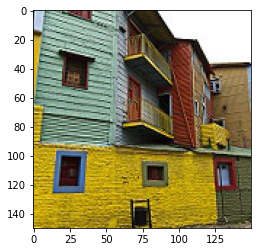

In [ ]:
%matplotlib inline

plt.imshow(image)

In [ ]:
# ===== Generators ==========================

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. /255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   rotation_range=40,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. /255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    target_size=(150, 150),
                                                    class_mode='categorical')     

validation_generator =  test_datagen.flow_from_directory(val_dir,
                                                    batch_size=32,
                                                    target_size=(150, 150),
                                                    class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
# ==== Pretrained model =====================

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
pre_trained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed8')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

87916544/87910968 [==============================] - 1s 0us/step
last layer output shape:  (None, 3, 3, 1280)


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers 
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
x = Flatten()(last_output)
x = Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)
outputs = Dense(6, activation="softmax")(x)

model = Model(inputs = pre_trained_model.input, outputs = outputs)

In [ ]:
model.compile(optimizer="Adam", 
              loss="binary_crossentropy",
              metrics = "accuracy")

In [ ]:
cp_path = "/content/drive/MyDrive/Models/intel_5class_model"

In [ ]:
early_stopping = EarlyStopping(monitor="val_accuracy", min_delta=0.0005, patience=3)
checkpoint = ModelCheckpoint(filepath=cp_path, monitor="val_accuracy", save_best_only=True)

In [ ]:
history = model.fit(x=train_generator, epochs=5, callbacks=[early_stopping,checkpoint], validation_data=validation_generator)

Epoch 1/5
439/439 [==============================] - 109s 249ms/step - loss: 0.2076 - accuracy: 0.8258 - val_loss: 0.1578 - val_accuracy: 0.8820
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/intel_5class_model/assets
Epoch 2/5
439/439 [==============================] - 109s 249ms/step - loss: 0.2052 - accuracy: 0.8225 - val_loss: 0.1559 - val_accuracy: 0.8937
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/intel_5class_model/assets
Epoch 3/5
439/439 [==============================] - 110s 250ms/step - loss: 0.2037 - accuracy: 0.8210 - val_loss: 0.1574 - val_accuracy: 0.8733
Epoch 4/5
439/439 [==============================] - 109s 248ms/step - loss: 0.2027 - accuracy: 0.8219 - val_loss: 0.1519 - val_accuracy: 0.8900
Epoch 5/5
439/439 [==============================] - 108s 246ms/step - loss: 0.1950 - accuracy: 0.8294 - val_loss: 0.1483 - val_accuracy: 0.9023
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/intel_5class_model/assets


In [ ]:
history1 = history

In [ ]:
history2 = history

In [ ]:
print(history1.history['accuracy'] + history2.history['accuracy'])
# print(history2.history['accuracy'])

[0.801624596118927, 0.81687331199646, 0.8291292786598206, 0.8232150673866272, 0.8282029628753662, 0.8247114419937134, 0.8257802724838257, 0.8225024938583374, 0.8210061192512512, 0.8219324350357056, 0.8294143080711365]


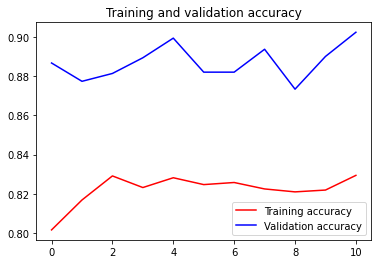

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()